## PHASE-1-Text Data Collection & Preprocessing
Collect text data relevant to stocks:

Financial news articles

Tweets / forums

Earnings call transcripts

Clean and preprocess text:

Remove punctuation, special characters, stopwords

Tokenize sentences/words

In [1]:
# Phase 1 - Cell 1: Install all needed libraries (fixed version)

# Step 1: Remove any conflicting versions first
!pip uninstall -y pyppeteer websockets

# Step 2: Install core libraries without pulling conflicting deps
!pip install -q newspaper3k snscrape beautifulsoup4 lxml requests pandas numpy tqdm nltk spacy langdetect pdfplumber vaderSentiment yahoo_fin --no-deps

# Step 3: Manually install safe versions of required deps
!pip install -q "websockets>=13.0,<15.1"
!pip install -q feedparser tinysegmenter jieba3k sgmllib3k

# Step 4: Verify
import websockets
print("✅ Websockets version:", websockets.__version__)



Found existing installation: websockets 15.0.1
Uninstalling websockets-15.0.1:
  Successfully uninstalled websockets-15.0.1
✅ Websockets version: 15.0.1


In [2]:
# Colab Cell 2 — NLTK downloads
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
# Colab Cell 3 — mount drive & create folders
from google.colab import drive
import os

drive.mount('/content/drive')

BASE = "/content/drive/MyDrive/Fin-R1_project_phase1"
subfolders = ["raw/html", "raw/transcripts", "cleaned", "logs", "scripts"]

for s in subfolders:
    os.makedirs(os.path.join(BASE, s), exist_ok=True)

print("✅ Base folder:", BASE)



Mounted at /content/drive
✅ Base folder: /content/drive/MyDrive/Fin-R1_project_phase1


In [4]:
# Colab Cell 4 — imports & helpers
import os, re, json, requests
from datetime import datetime
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import tqdm

import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])
STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def save_csv(df, path):
    df.to_csv(path, index=False, encoding="utf-8")

def save_jsonl(df, path):
    df.to_json(path, orient="records", lines=True, force_ascii=False)

def safe_get(url, headers=None, timeout=15):
    try:
        r = requests.get(url, headers=headers, timeout=timeout)
        r.raise_for_status()
        return r
    except Exception as e:
        print("GET error:", url, e)
        return None

print("✅ Imports ready. Stopwords loaded:", len(STOPWORDS))



✅ Imports ready. Stopwords loaded: 198


In [5]:
#Cell 5 — Yahoo Finance RSS scrape
from yahoo_fin import news

BASE_HTML = os.path.join(BASE, "raw/html")
os.makedirs(BASE_HTML, exist_ok=True)

articles = news.get_yf_rss("AAPL")  # Example: Apple

data = [[a["title"], a["link"]] for a in articles]
df_yahoo = pd.DataFrame(data, columns=["headline", "link"])

file_path = os.path.join(BASE_HTML, f"yahoo_news_{datetime.now().date()}.csv")
df_yahoo.to_csv(file_path, index=False)

print("✅ Scraped", len(df_yahoo), "news articles")
df_yahoo.head()



✅ Scraped 20 news articles


,headline,link
0,Nvidia Stock Rises. Sales From This Key Suppli...,https://finance.yahoo.com/m/e8965e0d-9071-33f9...
1,Shawbrook plans London IPO in 'vote of confide...,https://uk.finance.yahoo.com/news/shawbrook-lo...
2,UK's best-selling cars revealed,https://uk.finance.yahoo.com/news/uk-best-sell...
3,Nasdaq Has Become the Market of Choice for Dub...,https://finance.yahoo.com/m/9369296f-5a92-3676...
4,Prediction: This Underrated AI Company Could P...,https://www.fool.com/investing/2025/10/06/pred...


In [6]:
#Cell 6 — Reddit scrape (stocks subreddit)
url = "https://old.reddit.com/r/stocks/"
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

posts = soup.find_all("a", class_="title")
data = [[p.get_text(strip=True), p["href"]] for p in posts]

df_reddit = pd.DataFrame(data, columns=["post_title", "link"])
file_path = os.path.join(BASE, f"raw/reddit_stocks_{datetime.now().date()}.csv")
df_reddit.to_csv(file_path, index=False)

print("✅ Reddit posts scraped:", len(df_reddit))
df_reddit.head()



✅ Reddit posts scraped: 0


,post_title,link


In [7]:
#Cell 7 — Download transcript (SEC filing example)
BASE_TRANS = os.path.join(BASE, "raw/transcripts")
os.makedirs(BASE_TRANS, exist_ok=True)

url = "https://www.sec.gov/Archives/edgar/data/320193/000032019323000066/aapl-20230930.htm"
response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})

file_path = os.path.join(BASE_TRANS, "sample_transcript.html")
with open(file_path, "w", encoding="utf-8") as f:
    f.write(response.text)

print("✅ Transcript saved at:", file_path)



✅ Transcript saved at: /content/drive/MyDrive/Fin-R1_project_phase1/raw/transcripts/sample_transcript.html


In [8]:
#Cell 8 — Clean transcript

from bs4 import BeautifulSoup
import os

BASE_TRANS = "/content/drive/MyDrive/Fin-R1_project_phase1/raw/transcripts"
BASE_CLEAN = "/content/drive/MyDrive/Fin-R1_project_phase1/cleaned"
os.makedirs(BASE_CLEAN, exist_ok=True)

# Read the raw transcript
file_path = os.path.join(BASE_TRANS, "sample_transcript.html")
with open(file_path, "r", encoding="utf-8") as f:
    soup = BeautifulSoup(f, "html.parser")

# Extract cleaned text
text = " ".join([p.get_text(strip=True) for p in soup.find_all("p")])

# Save into cleaned folder
save_path = os.path.join(BASE_CLEAN, "sample_transcript_cleaned.txt")
with open(save_path, "w", encoding="utf-8") as f:
    f.write(text)

print("✅ Transcript cleaned and saved at:", save_path)
print(text[:500])




✅ Transcript cleaned and saved at: /content/drive/MyDrive/Fin-R1_project_phase1/cleaned/sample_transcript_cleaned.txt
To allow for equitable access to all users, SEC reserves the right to limit requests originating from undeclared automated tools. Your request has been identified as part of a network of automated tools outside of the acceptable policy and will be managed until action is taken to declare your traffic. Please declare your traffic by updating your user agent to include company specific information. For best practices on efficiently downloading information from SEC.gov, including the latest EDGAR f


In [9]:
#Cell 9 — Clean Yahoo news headlines
import re
import os
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = " ".join([word for word in text.split() if word not in STOPWORDS])
    return text

df_yahoo["cleaned"] = df_yahoo["headline"].apply(clean_text)

# Save cleaned in a separate folder
CLEAN_DIR = "/content/drive/MyDrive/Fin-R1_project_phase1/cleaned"
os.makedirs(CLEAN_DIR, exist_ok=True)

save_path = os.path.join(CLEAN_DIR, "yahoo_news_cleaned.csv")
df_yahoo.to_csv(save_path, index=False)

print("✅ Cleaned Yahoo news saved at:", save_path)
df_yahoo.head()




✅ Cleaned Yahoo news saved at: /content/drive/MyDrive/Fin-R1_project_phase1/cleaned/yahoo_news_cleaned.csv


,headline,link,cleaned
0,Nvidia Stock Rises. Sales From This Key Suppli...,https://finance.yahoo.com/m/e8965e0d-9071-33f9...,nvidia stock rises sales key supplier signals ...
1,Shawbrook plans London IPO in 'vote of confide...,https://uk.finance.yahoo.com/news/shawbrook-lo...,shawbrook plans london ipo vote confidence uk ...
2,UK's best-selling cars revealed,https://uk.finance.yahoo.com/news/uk-best-sell...,uks bestselling cars revealed
3,Nasdaq Has Become the Market of Choice for Dub...,https://finance.yahoo.com/m/9369296f-5a92-3676...,nasdaq become market choice dubious pennystock...
4,Prediction: This Underrated AI Company Could P...,https://www.fool.com/investing/2025/10/06/pred...,prediction underrated ai company could power n...


In [10]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [11]:
#Cell 10 — Tokenization check
from nltk.tokenize import word_tokenize, sent_tokenize

sample = df_yahoo["cleaned"].iloc[0]
print("Original:", df_yahoo["headline"].iloc[0])
print("Cleaned:", sample)
print("Word tokens:", word_tokenize(sample))
print("Sentence tokens:", sent_tokenize(df_yahoo["headline"].iloc[0]))


Original: Nvidia Stock Rises. Sales From This Key Supplier Signals Strong AI Demand.
Cleaned: nvidia stock rises sales key supplier signals strong ai demand
Word tokens: ['nvidia', 'stock', 'rises', 'sales', 'key', 'supplier', 'signals', 'strong', 'ai', 'demand']
Sentence tokens: ['Nvidia Stock Rises.', 'Sales From This Key Supplier Signals Strong AI Demand.']


## PHASE-2– LLM Feature Extraction
Run an LLM (e.g., GPT) to generate features:

Sentiment analysis → daily sentiment score    

  Summarization → extract key points from earnings reports              
  
  Topic extraction → identify market trends or keywords


In [12]:
#Colab Cell 1 — Install required libs
!pip install -q vaderSentiment sumy spacy yake
!python -m spacy download en_core_web_sm



  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.9/355.9 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 140.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [13]:
#Cell 2 — Imports & initial setup
import os
import pandas as pd
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
import yake

# Load spacy
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

# Sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()



In [14]:
#Cell 3 — Load cleaned news/earnings data
# Load cleaned Yahoo news (from Phase 1)
# Example: cleaned Yahoo news
df_news = pd.read_csv("/content/drive/MyDrive/Fin-R1_project_phase1/cleaned/yahoo_news_cleaned.csv")
print(f"✅ Loaded {len(df_news)} news rows")
df_news.head()


✅ Loaded 20 news rows


,headline,link,cleaned
0,Nvidia Stock Rises. Sales From This Key Suppli...,https://finance.yahoo.com/m/e8965e0d-9071-33f9...,nvidia stock rises sales key supplier signals ...
1,Shawbrook plans London IPO in 'vote of confide...,https://uk.finance.yahoo.com/news/shawbrook-lo...,shawbrook plans london ipo vote confidence uk ...
2,UK's best-selling cars revealed,https://uk.finance.yahoo.com/news/uk-best-sell...,uks bestselling cars revealed
3,Nasdaq Has Become the Market of Choice for Dub...,https://finance.yahoo.com/m/9369296f-5a92-3676...,nasdaq become market choice dubious pennystock...
4,Prediction: This Underrated AI Company Could P...,https://www.fool.com/investing/2025/10/06/pred...,prediction underrated ai company could power n...


In [15]:
#Cell 4 — Sentiment Analysis
def get_sentiment(text):
    score = sentiment_analyzer.polarity_scores(text)
    return score['compound']

df_news['sentiment'] = df_news['cleaned'].apply(get_sentiment)
print("✅ Sentiment added")
df_news.head()



✅ Sentiment added


,headline,link,cleaned,sentiment
0,Nvidia Stock Rises. Sales From This Key Suppli...,https://finance.yahoo.com/m/e8965e0d-9071-33f9...,nvidia stock rises sales key supplier signals ...,0.4215
1,Shawbrook plans London IPO in 'vote of confide...,https://uk.finance.yahoo.com/news/shawbrook-lo...,shawbrook plans london ipo vote confidence uk ...,0.5106
2,UK's best-selling cars revealed,https://uk.finance.yahoo.com/news/uk-best-sell...,uks bestselling cars revealed,0.0000
3,Nasdaq Has Become the Market of Choice for Dub...,https://finance.yahoo.com/m/9369296f-5a92-3676...,nasdaq become market choice dubious pennystock...,-0.3612
4,Prediction: This Underrated AI Company Could P...,https://www.fool.com/investing/2025/10/06/pred...,prediction underrated ai company could power n...,0.4019


In [16]:
# ✅ Identify the correct date column dynamically
date_col = None
for col in df_news.columns:
    if 'date' in col.lower() or 'time' in col.lower():
        date_col = col
        break

if date_col is None:
    raise KeyError("⚠️ No date-like column found in df_news. Please check your dataset columns.")

print(f"🕒 Using '{date_col}' as the date column for aggregation")

# ✅ Ensure a proper date column
df_news['date'] = pd.to_datetime(df_news[date_col], errors='coerce').dt.date

# ✅ Aggregate daily sentiment for merging with price data
daily_sent = (
    df_news.groupby('date', as_index=False)
    .agg({
        'sentiment': 'mean',   # average sentiment per day
        'headline': 'count'    # number of news articles per day
    })
    .rename(columns={
        'headline': 'news_count',
        'sentiment': 'avg_sentiment'
    })
)

print("✅ Daily sentiment data prepared successfully:")
display(daily_sent.head())


🕒 Using 'sentiment' as the date column for aggregation
✅ Daily sentiment data prepared successfully:


,date,avg_sentiment,news_count
0,1970-01-01,0.094045,20


In [17]:
# Cell 5 — Load transcript & clean (updated)
from bs4 import BeautifulSoup
import os

# Path to transcript HTML
file_path = "/content/drive/MyDrive/Fin-R1_project_phase1/raw/transcripts/sample_transcript.html"

# Check if file exists
if not os.path.exists(file_path):
    print(f"⚠️ Transcript file not found: {file_path}")
    filtered_text = ""
else:
    # Load HTML
    with open(file_path, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "html.parser")

    # Extract paragraphs
    paragraphs = [p.get_text(strip=True) for p in soup.find_all("p") if len(p.get_text(strip=True)) > 50]
    transcript_text = " ".join(paragraphs)

    # Remove SEC boilerplate and repeated warnings
    filtered_text = " ".join([line for line in transcript_text.split(". ")
                              if not any(word.lower() in line.lower()
                                         for word in ["sec", "privacy", "computer system", "prohibited", "automated tools"])])

    if len(filtered_text) == 0:
        print("⚠️ Warning: No meaningful transcript content found. Using full transcript.")
        filtered_text = transcript_text  # fallback to full text

    # Save cleaned transcript
    save_path = "/content/drive/MyDrive/Fin-R1_project_phase1/cleaned/sample_transcript_cleaned.txt"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, "w", encoding="utf-8") as f:
        f.write(filtered_text)

    print("✅ Transcript cleaned and saved at:", save_path)
    print("\nPreview (first 500 chars):\n")
    print(filtered_text[:500])

✅ Transcript cleaned and saved at: /content/drive/MyDrive/Fin-R1_project_phase1/cleaned/sample_transcript_cleaned.txt

Preview (first 500 chars):

Please declare your traffic by updating your user agent to include company specific information Thank you for your interest in the U.S We reserve the right to block IP addresses that submit excessive requests Â§Â§ 1001 and 1030) We reserve the right to block IP addresses that submit excessive requests Note:We do not offer technical support for developing or debugging scripted downloading processes.


In [18]:
#Cell 6 — Summarization
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

# Summarize using LexRank
if filtered_text:
    parser = PlaintextParser.from_string(filtered_text, Tokenizer("english"))
    summarizer = LexRankSummarizer()
    summary_sentences = summarizer(parser.document, sentences_count=10)
    summary = " ".join([str(sentence) for sentence in summary_sentences])

    print("✅ Transcript Summary:\n")
    print(summary[:500] + "..." if len(summary) > 500 else summary)
else:
    print("⚠️ No text to summarize.")



✅ Transcript Summary:

Please declare your traffic by updating your user agent to include company specific information Thank you for your interest in the U.S We reserve the right to block IP addresses that submit excessive requests Â§Â§ 1001 and 1030) We reserve the right to block IP addresses that submit excessive requests Note:We do not offer technical support for developing or debugging scripted downloading processes.


In [19]:
#Cell 7 — Topic Extraction using YAKE
import yake

# Extract keywords/topics
if filtered_text:
    kw_extractor = yake.KeywordExtractor(lan="en", n=3, top=10)
    keywords = kw_extractor.extract_keywords(filtered_text)
    topics = [kw[0] for kw in keywords]

    print("✅ Extracted Topics:\n")
    print(topics)
else:
    print("⚠️ No text available for topic extraction.")



✅ Extracted Topics:

['submit excessive requests', 'excessive requests Note', 'scripted downloading processes', 'include company specific', 'company specific information', 'offer technical support', 'debugging scripted downloading', 'block IP addresses', 'addresses that submit', 'submit excessive']


In [20]:
print(df_news.columns)
df_news.head(3)


Index(['headline', 'link', 'cleaned', 'sentiment', 'date'], dtype='object')


,headline,link,cleaned,sentiment,date
0,Nvidia Stock Rises. Sales From This Key Suppli...,https://finance.yahoo.com/m/e8965e0d-9071-33f9...,nvidia stock rises sales key supplier signals ...,0.4215,1970-01-01
1,Shawbrook plans London IPO in 'vote of confide...,https://uk.finance.yahoo.com/news/shawbrook-lo...,shawbrook plans london ipo vote confidence uk ...,0.5106,1970-01-01
2,UK's best-selling cars revealed,https://uk.finance.yahoo.com/news/uk-best-sell...,uks bestselling cars revealed,0.0000,1970-01-01


## Phase 3 – Integration with Existing Model
Combine LLM-derived features with historical OHLCV stock data
   
Modify ML model (Linear Regression, Random Forest, etc.) to include these new features

In [21]:
#Cell 1 — Install required libraries
!pip install -q yfinance pandas numpy scikit-learn matplotlib



In [22]:
# Cell 2 — imports
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [23]:
# Cell 3 — Fetch Stock Price Data
TICKER = "AAPL"
start_date = "2025-08-21"
end_date = "2025-09-25"

df_price = yf.download(TICKER, start=start_date, end=end_date, progress=False)
df_price.reset_index(inplace=True)  # Date becomes a column

# Drop duplicates and keep 'Close' column
df_price = df_price.loc[:, ~df_price.columns.duplicated()]
df_price['date'] = pd.to_datetime(df_price['Date'])
df_price = df_price.drop(columns=['Date'])

# Preview
print("✅ Fetched price data:")
df_price.head()


/tmp/ipython-input-4279554006.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_price = yf.download(TICKER, start=start_date, end=end_date, progress=False)


✅ Fetched price data:


/tmp/ipython-input-4279554006.py:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_price = df_price.drop(columns=['Date'])


Price,Close,High,Low,Open,Volume,date
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,
0,224.899994,226.520004,223.779999,226.270004,30621200,2025-08-21
1,227.759995,229.089996,225.410004,226.169998,42477800,2025-08-22
2,227.160004,229.300003,226.229996,226.479996,30983100,2025-08-25
3,229.309998,229.490005,224.690002,226.869995,54575100,2025-08-26
4,230.490005,230.899994,228.259995,228.610001,31259500,2025-08-27


In [24]:
# Cell 4 — Fetch OHLCV Price Data
import yfinance as yf

# Download with full OHLCV columns
df_price = yf.download("AAPL", start="2023-01-01", end="2023-12-31", auto_adjust=False)

# Reset index
df_price = df_price.reset_index()

# Rename columns for consistency
df_price.rename(columns={'Date': 'date', 'Adj Close': 'Close'}, inplace=True)

# Keep only required columns
df_price = df_price[['date', 'Close', 'Open', 'High', 'Low', 'Volume']]

# Ensure datetime
df_price['date'] = pd.to_datetime(df_price['date'])

print("✅ Price dataset shape:", df_price.shape)
display(df_price.head())


[*********************100%***********************]  1 of 1 completed

✅ Price dataset shape: (250, 7)


Price        date       Close                    Open        High         Low  \
Ticker                   AAPL        AAPL        AAPL        AAPL        AAPL   
0      2023-01-03  123.330650  125.070000  130.279999  130.899994  124.169998   
1      2023-01-04  124.602692  126.360001  126.889999  128.660004  125.080002   
2      2023-01-05  123.281334  125.019997  127.129997  127.769997  124.760002   
3      2023-01-06  127.817360  129.619995  126.010002  130.289993  124.889999   
4      2023-01-09  128.339996  130.149994  130.470001  133.410004  129.889999   

Price      Volume  
Ticker       AAPL  
0       112117500  
1        89113600  
2        80962700  
3        87754700  
4        70790800

In [30]:
# ✅ Reload or fetch stock price data correctly
import yfinance as yf

# Example: Using Apple (AAPL) — change symbol if needed
df_price = yf.download("AAPL", start="2023-01-01", end="2023-12-31")

# Reset index and rename date column
df_price = df_price.reset_index().rename(columns={'Date': 'date'})

# Keep only useful columns
df_price = df_price[['date', 'Open', 'High', 'Low', 'Close', 'Volume']]

print("✅ Price data loaded successfully:")
print(df_price.head())



/tmp/ipython-input-256536808.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_price = yf.download("AAPL", start="2023-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed

✅ Price data loaded successfully:
Price        date        Open        High         Low       Close     Volume
Ticker                   AAPL        AAPL        AAPL        AAPL       AAPL
0      2023-01-03  128.468194  129.079567  122.443165  123.330650  112117500
1      2023-01-04  125.125320  126.870708  123.340494  124.602692   89113600
2      2023-01-05  125.361991  125.993089  123.024955  123.281334   80962700
3      2023-01-06  124.257571  128.478040  123.153145  127.817360   87754700
4      2023-01-09  128.655553  131.554669  128.083618  128.339996   70790800


In [31]:
# Cell 5 — Merge Price & Sentiment Data
# ---------------- Phase 3 – Cell 5 (Debug + Final Fix) ----------------
import pandas as pd

# Show what columns exist before cleaning
print("🔍 Original Columns:", df_price.columns.tolist())

# ✅ Flatten MultiIndex if needed
if isinstance(df_price.columns, pd.MultiIndex):
    df_price.columns = ['_'.join([str(c) for c in col if c]) for col in df_price.columns]
else:
    df_price.columns = df_price.columns.astype(str)

print("📊 After flattening:", df_price.columns.tolist())

# ✅ Try to find columns that look like price info
possible_cols = [c for c in df_price.columns if any(x in c.lower() for x in ['open', 'high', 'low', 'close', 'volume'])]
print("🧩 Detected price-related columns:", possible_cols)

# ✅ Handle common cases like 'AAPL_Open', 'AAPL.Close', etc.
rename_map = {}
for c in possible_cols:
    lower = c.lower()
    if 'open' in lower: rename_map[c] = 'Open'
    elif 'high' in lower: rename_map[c] = 'High'
    elif 'low' in lower: rename_map[c] = 'Low'
    elif 'close' in lower: rename_map[c] = 'Close'
    elif 'volume' in lower: rename_map[c] = 'Volume'

df_price.rename(columns=rename_map, inplace=True)
print("✅ After renaming:", df_price.columns.tolist())

# ✅ Reset and standardize
df_price = df_price.reset_index(drop=False)

# ✅ Ensure we have a 'date' column
date_col = None
for col in df_price.columns:
    if 'date' in col.lower():
        date_col = col
        break

if date_col:
    df_price.rename(columns={date_col: 'date'}, inplace=True)
else:
    raise KeyError("No column found for 'date' — please check your df_price head().")

# ✅ Keep only relevant columns
keep_cols = ['date', 'Open', 'High', 'Low', 'Close', 'Volume']
df_price = df_price[[c for c in keep_cols if c in df_price.columns]].copy()

print("✅ Final cleaned columns:", df_price.columns.tolist())

# ✅ Convert date and merge
df_price['date'] = pd.to_datetime(df_price['date'], errors='coerce')
daily_sent['date'] = pd.to_datetime(daily_sent['date'], errors='coerce')

df = pd.merge(df_price, daily_sent, on='date', how='left')
df['avg_sentiment'] = df['avg_sentiment'].ffill().fillna(0.0)
df['news_count'] = df['news_count'].fillna(0)

# Add lag features
df['sentiment_lag0'] = df['avg_sentiment']
df['sentiment_lag1'] = df['avg_sentiment'].shift(1).fillna(0)
df['sentiment_lag2'] = df['avg_sentiment'].shift(2).fillna(0)

# Compute returns
if 'Close' in df.columns:
    df['return'] = df['Close'].pct_change()
    df['target_return_next'] = df['return'].shift(-1)
else:
    print("⚠️ Warning: 'Close' column still not found — check printed columns above!")
    df['return'] = 0
    df['target_return_next'] = 0

df.dropna(subset=['target_return_next'], inplace=True)

feature_cols = ['Close', 'sentiment_lag0', 'sentiment_lag1', 'sentiment_lag2', 'news_count']
X = df[[c for c in feature_cols if c in df.columns]].copy()
y = df['target_return_next'].copy() if 'target_return_next' in df.columns else None

print("✅ Final merged dataset shape:", df.shape)
df.head(3)

🔍 Original Columns: [('date', ''), ('Open', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Close', 'AAPL'), ('Volume', 'AAPL')]
📊 After flattening: ['date', 'Open_AAPL', 'High_AAPL', 'Low_AAPL', 'Close_AAPL', 'Volume_AAPL']
🧩 Detected price-related columns: ['Open_AAPL', 'High_AAPL', 'Low_AAPL', 'Close_AAPL', 'Volume_AAPL']
✅ After renaming: ['date', 'Open', 'High', 'Low', 'Close', 'Volume']
✅ Final cleaned columns: ['date', 'Open', 'High', 'Low', 'Close', 'Volume']
✅ Final merged dataset shape: (249, 13)


,date,Open,High,Low,Close,Volume,avg_sentiment,news_count,sentiment_lag0,sentiment_lag1,sentiment_lag2,return,target_return_next
0,2023-01-03,128.468194,129.079567,122.443165,123.330650,112117500,0.0,0.0,0.0,0.0,0.0,NaN,0.010314
1,2023-01-04,125.125320,126.870708,123.340494,124.602692,89113600,0.0,0.0,0.0,0.0,0.0,0.010314,-0.010605
2,2023-01-05,125.361991,125.993089,123.024955,123.281334,80962700,0.0,0.0,0.0,0.0,0.0,-0.010605,0.036794


In [34]:
# ---Cell 6: Model Training and Evaluation (Fixed NaN issue) ---

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Drop unnecessary columns
X = df.drop(columns=['target_return_next', 'date'])
y = df['target_return_next']

# ✅ Handle missing values
# Replace NaN with 0 (or you can use forward fill if that makes more sense for time series)
X = X.fillna(0)
y = y.fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# --- Random Forest Regressor ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# --- Metrics Function ---
def print_metrics(model_name, y_true, y_pred):
    print(f"\n📊 {model_name} Performance:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.6f}")

print_metrics("Linear Regression", y_test, y_pred_lr)
print_metrics("Random Forest", y_test, y_pred_rf)



📊 Linear Regression Performance:
R² Score: -0.1071
MAE: 0.008216
RMSE: 0.010552

📊 Random Forest Performance:
R² Score: -0.1805
MAE: 0.008472
RMSE: 0.010896


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


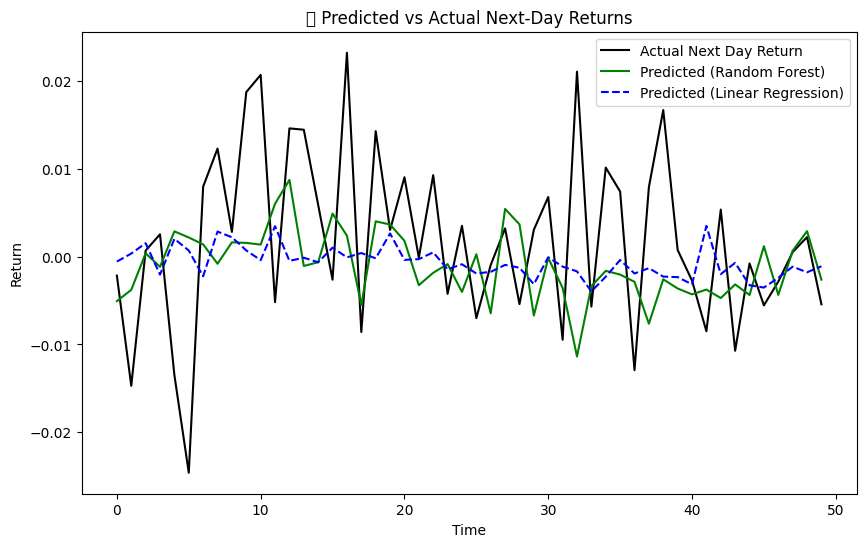

In [35]:
# --- Phase 3 Cell 7: Visualization of Predictions ---

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual Next Day Return', color='black')
plt.plot(y_pred_rf, label='Predicted (Random Forest)', color='green')
plt.plot(y_pred_lr, label='Predicted (Linear Regression)', color='blue', linestyle='--')
plt.title("📈 Predicted vs Actual Next-Day Returns")
plt.xlabel("Time")
plt.ylabel("Return")
plt.legend()
plt.show()
